In [ ]:
!kaggle datasets download -d umairnasir14/all-kaggle-questions-on-qoura-dataset
!ls /content

all-kaggle-questions-on-qoura-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
 all-kaggle-questions-on-qoura-dataset.zip
 drive
'Kaggle related questions on Qoura - Questions.csv'
 sample_data


In [ ]:
!unzip /content/all-kaggle-questions-on-qoura-dataset.zip
!ls /content

Archive:  /content/all-kaggle-questions-on-qoura-dataset.zip
replace Kaggle related questions on Qoura - Questions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Kaggle related questions on Qoura - Questions.csv  
 all-kaggle-questions-on-qoura-dataset.zip
 drive
'Kaggle related questions on Qoura - Questions.csv'
 sample_data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/Kaggle related questions on Qoura - Questions.csv")
df.head()

,Questions,Followers,Answered,Link
0,How do I start participating in Kaggle competi...,1200,1,/How-do-I-start-participating-in-Kaggle-compet...
1,Is Kaggle dead?,181,1,/Is-Kaggle-dead
2,How should a beginner get started on Kaggle?,388,1,/How-should-a-beginner-get-started-on-Kaggle
3,What are some alternatives to Kaggle?,201,1,/What-are-some-alternatives-to-Kaggle
4,What Kaggle competitions should a beginner sta...,273,1,/What-Kaggle-competitions-should-a-beginner-st...


In [ ]:
df['Answered'].value_counts()

1    661
0    505
Name: Answered, dtype: int64

In [ ]:
df = df.drop(['Followers'], axis=1)
df.head()

,Questions,Answered,Link
0,How do I start participating in Kaggle competi...,1,/How-do-I-start-participating-in-Kaggle-compet...
1,Is Kaggle dead?,1,/Is-Kaggle-dead
2,How should a beginner get started on Kaggle?,1,/How-should-a-beginner-get-started-on-Kaggle
3,What are some alternatives to Kaggle?,1,/What-are-some-alternatives-to-Kaggle
4,What Kaggle competitions should a beginner sta...,1,/What-Kaggle-competitions-should-a-beginner-st...


In [ ]:
df.isna().sum()

Questions    0
Answered     0
Link         0
dtype: int64

In [ ]:
df['Link'].duplicated().sum()

0

In [ ]:
len_df = len(df)
len_df

1166

In [ ]:
df['Link'][0]

'/How-do-I-start-participating-in-Kaggle-competitions-What-basic-data-analysis-do-people-do-and-how-do-people-know-which-models-to-apply-How-do-they-make-improvements'

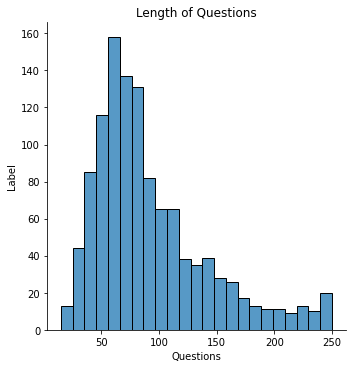

In [ ]:
sns.displot(df['Questions'].apply(lambda x: len(x)))
plt.title('Length of Questions')
plt.ylabel('Label')
plt.show()

## Extract Feature Vectors

In [ ]:
!pip install transformers > /dev/null 2>&1

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertModel
from typing import List
import torch

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sentences = df['Questions'].to_numpy()
sentences

array(['How do I start participating in Kaggle competitions? What basic data analysis do people do and how do people know which models to apply? How do they make improvements?',
       'Is Kaggle dead?', 'How should a beginner get started on Kaggle?',
       ..., 'What are some good resources for learning R?',
       'What is the best way to start learning R? I would spend money on a course, but would obviously prefer a free resource. I’m familiar with Java.',
       'What are all the companies that Google has ever acquired?'],
      dtype=object)

In [ ]:
class QuestionDataset(torch.utils.data.Dataset):
    def __init__(self, sentences: List[str]):
        super(QuestionDataset).__init__()
        self.sentences = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx]

In [ ]:
question_dataset = QuestionDataset(sentences)
for i in range(4):
    sample = question_dataset[i]
    print(sample)

How do I start participating in Kaggle competitions? What basic data analysis do people do and how do people know which models to apply? How do they make improvements?
Is Kaggle dead?
How should a beginner get started on Kaggle?
What are some alternatives to Kaggle?


In [ ]:
dataloader = torch.utils.data.DataLoader(
    question_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0)

In [ ]:
def batch_to_feature_vector(batch_sentences: List[str], batch_size: int):
    inputs = tokenizer(batch_sentences, return_tensors='pt', padding=True)
    outputs = model(**inputs)  # (64, max_length, 768)
    last_hidden_state = outputs.last_hidden_state.detach().mean(dim=1).reshape(batch_size, -1).numpy()
    return last_hidden_state  # (64, 768)

In [ ]:
feature_vectors = []
for i, batch in enumerate(dataloader):
    batch += ["" for _ in range(64-len(batch))]
    features = batch_to_feature_vector(batch, batch_size=64)
    feature_vectors.append(features)
feature_vectors = torch.tensor(feature_vectors).reshape(-1, 768)[:len(df)]

In [ ]:
feature_vectors.shape

torch.Size([1166, 768])

## K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=256, random_state=0).fit(feature_vectors)

In [ ]:
kmeans.labels_

array([ 27,  55, 213, ...,  90,  84, 156], dtype=int32)

In [ ]:
predictions = kmeans.predict(feature_vectors)

In [ ]:
for n in range(0, 10):
    print(df['Questions'][predictions == n].tolist())

['Will I be able to work with the datasets of Kaggle problems without downloading them?', 'How do people reduce the "activation energy" it takes to go into Kaggle (and other) Machine Learning contests?', 'What are your thoughts on leakage being so common in Kaggle competitions and how to prevent it in the future?']
['Do recruiters really care about Kaggle achievements or successfully completed courses in Coursera?', 'What are the tricks and tips for performing better at Kaggle?', 'Are the solutions/results of kaggle competitions available?', 'What is the most interesting thing about working at Kaggle?', 'Has Kaggle stopped posting job listings?', 'What was the idea behind starting up Kaggle?', 'When performing on Kaggle, how do I know if my model is doing well?', 'Kaggle: What are the techniques used to reduce the number of columns before predicting the dependent variable? Please see description', 'How do I become better at Kaggle? I know Python programming well, but not any statistics

In [ ]:
l = []
for n in range(0, 256):
    l.append(df['Questions'][predictions == n].tolist())
l

[['Will I be able to work with the datasets of Kaggle problems without downloading them?',
  'How do people reduce the "activation energy" it takes to go into Kaggle (and other) Machine Learning contests?',
  'What are your thoughts on leakage being so common in Kaggle competitions and how to prevent it in the future?'],
 ['Do recruiters really care about Kaggle achievements or successfully completed courses in Coursera?',
  'What are the tricks and tips for performing better at Kaggle?',
  'Are the solutions/results of kaggle competitions available?',
  'What is the most interesting thing about working at Kaggle?',
  'Has Kaggle stopped posting job listings?',
  'What was the idea behind starting up Kaggle?',
  'When performing on Kaggle, how do I know if my model is doing well?',
  'Kaggle: What are the techniques used to reduce the number of columns before predicting the dependent variable? Please see description',
  'How do I become better at Kaggle? I know Python programming well,